In [1]:
%pylab inline

from PyTools import err, binner, nbins
from sklearn.cluster import DBSCAN
from string import join
import pyfits as pyf
from scipy.ndimage.filters import gaussian_filter
import pres_style, os

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
def put_FITS_names(table):
    descr = table.dtype.descr
    for i in xrange(3): descr.pop(0)
    descr = [("input_file", "|S25")] + descr

    new_table = zeros(table.shape[0], dtype=descr)
    new_table["input_file"] = ["spSpec-{0:05d}-{1:04d}-{2:03d}.fit".format(r["mjd"], r["plate"], r["fiberID"]) for r in table]
    for f in new_table.dtype.names[1:]:
        new_table[f] = table[f]
    
    return new_table

par_lbs = [r"$M_\star$", r"$\left<\log{t_\star}\right>_M$", r"$\left<\log{t_\star}\right>_L$",
           r"$\left<\log{Z_\star/Z\odot}\right>_M$", r"$\left<\log{Z_\star/Z\odot}\right>_L$", r"$A_V$"]
res_lbs = [r"$\Delta_r M_\star$", r"$\Delta\left<\log{t_\star}\right>_M$", r"$\Delta\left<\log{t_\star}\right>_L$",
           r"$\Delta\left<\log{Z_\star/Z\odot}\right>_M$", r"$\Delta\left<\log{Z_\star/Z\odot}\right>_L$",
           r"$\Delta A_V$"]

od = os.path.expandvars("$HOME/Documents/Papers/photofit_near_paper/")

In [3]:
#READ TABLES

catalog = genfromtxt("catalog.txt", dtype=None, names=True)
spec_ne = genfromtxt("spec_ne.txt", dtype=None, names=True)
jpas_ye = genfromtxt("jpas_ye.txt", dtype=None, names=True)
jpas_ne = genfromtxt("jpas_ne.txt", dtype=None, names=True)
jpas_me = genfromtxt("jpas_me.txt", dtype=None, names=True)
gal2005 = genfromtxt("gal2005.txt", dtype=None, names=True)
galtab2 = array([[ 8.91, -0.60, -1.11, -0.00, 9.06, 8.80,  9.46],
                 [ 9.11, -0.61, -1.07, -0.00, 9.09, 8.81,  9.48],
                 [ 9.31, -0.65, -1.10, -0.05, 9.11, 8.85,  9.44],
                 [ 9.51, -0.61, -1.03, -0.01, 9.17, 8.89,  9.49],
                 [ 9.72, -0.52, -0.97,  0.05, 9.23, 8.94,  9.57],
                 [ 9.91, -0.41, -0.90,  0.09, 9.32, 9.00,  9.71],
                 [10.11, -0.23, -0.80,  0.14, 9.46, 9.09,  9.85],
                 [10.31, -0.11, -0.65,  0.17, 9.61, 9.23,  9.93],
                 [10.51, -0.01, -0.41,  0.20, 9.73, 9.34,  9.98],
                 [10.72,  0.04, -0.24,  0.22, 9.82, 9.48, 10.03],
                 [10.91,  0.07, -0.14,  0.24, 9.87, 9.60, 10.06],
                 [11.11,  0.10, -0.09,  0.25, 9.90, 9.67, 10.08],
                 [11.31,  0.12, -0.06,  0.26, 9.92, 9.72, 10.09],
                 [11.51,  0.13, -0.04,  0.28, 9.94, 9.75, 10.11],
                 [11.72,  0.14, -0.03,  0.29, 9.95, 9.76, 10.12],
                 [11.91,  0.15, -0.03,  0.30, 9.96, 9.77, 10.12]])
Lfrac = put_FITS_names(genfromtxt("lumfrac.txt", dtype=None, names=True))
SN = genfromtxt("snr.txt")

In [4]:
#COMMON QUANTITIES

lcolor = catalog["u_mag"] - catalog["r_mag"]
rfract = 10**(-0.4*Lfrac["fiberMag_r"])/10**(-0.4*Lfrac["petroMag_r"])

bmask = lcolor < 2.22
rmask = ~bmask
nmask = array([n in jpas_ne["input_file"] for n in jpas_me["input_file"]], dtype=bool)
gmask = array([n in gal2005["input_file"] for n in catalog["input_file"]], dtype=bool)

kw = "M_mod log_t_M_mod log_t_L_mod log_Z_M_mod log_Z_L_mod Av_mod".split()
rl = [False]*6
lb = [r"$\Delta \log{M_\star/M\odot}$", r"$\Delta\left<\log{t_\star}\right>_M$",
      r"$\Delta\left<\log{t_\star}\right>_L$", r"$\Delta\left<\log{Z_\star/Z\odot}\right>_M$",
      r"$\Delta\left<\log{Z_\star/Z\odot}\right>_L$", r"$\Delta A_V$"]

In [5]:
zmask = (spec_ne[gmask]["log_Z_L_mod"]>log10(0.004/0.02))&(gal2005["z_mode"]>log10(0.004/0.02))
sfgal = lcolor[gmask][zmask]<2.22
pagal = lcolor[gmask][zmask]>2.22

s = spec_ne[gmask][zmask]
g = gal2005[zmask]
cat = catalog[gmask][zmask]
rat = rfract[gmask][zmask]

X = zeros((s.size, 2))
X[:, 0], X[:, 1] = s["log_t_L_mod"], s["log_Z_L_mod"]

print "tables match? ", all((g["input_file"]==s["input_file"])&(s["input_file"]==cat["input_file"]))

tables match?  True


In [6]:
db = DBSCAN(eps=0.03, min_samples=20).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

labels[labels==2] = 1
labels[labels==3] = 0
labels[labels==4] = -1
labels[labels==5] = 1
labels[labels==6] = 1

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

unique_labels = set(labels)
c1m = labels==0
c2m = labels==1
#colors = plt.cm.jet(np.linspace(0, 1, len(unique_labels)))
colors = ["#114477", "#117733"]

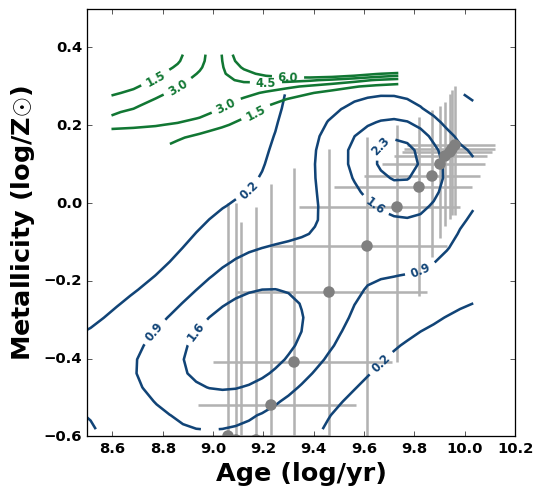

In [7]:
fig = figure(figsize=(6, 6))
xlim(8.5, 10.2)
ylim(-0.6, 0.5)
xlabel("Age (log/yr)")
ylabel("Metallicity (log/Z$\odot$)")

errorbar(galtab2[:, 4], galtab2[:, 1], xerr=[abs(galtab2[:, 4]-galtab2[:, 5]), abs(galtab2[:, 4]-galtab2[:, 6])],
        yerr=[abs(galtab2[:, 1]-galtab2[:, 2]), abs(galtab2[:, 1]-galtab2[:, 3])], fmt="o", color="0.5",
         ecolor="0.7", ms=9, capsize=0)

#CONTOURS FOR CLUSTER #1
nx, xi, xf, bsx = nbins(X[c1m, 0])
ny, yi, yf, bsy = nbins(X[c1m, 1])

H, xe, ye = histogram2d(X[c1m, 0], X[c1m, 1], bins=(nx, ny), normed=True)
H = gaussian_filter(H, sigma=2)

cont = contour(xe[:- 1], ye[:- 1], H.T, colors=colors[0], levels=np.arange(0.2, 14, 0.7))
clabel(cont, fontsize=9, fmt="%.1f", inline=True)

#CONTOURS FOR CLUSTER #2
nx, xi, xf, bsx = nbins(X[c2m, 0])
ny, yi, yf, bsy = nbins(X[c2m, 1])

H, xe, ye = histogram2d(X[c2m, 0], X[c2m, 1], bins=(nx, ny), normed=True)
H = gaussian_filter(H, sigma=2)

cont = contour(xe[:- 1], ye[:- 1], H.T, colors=colors[1], levels=np.arange(1.5, 7, 1.5))
clabel(cont, fontsize=9, fmt="%.1f", inline=True)

#savefig(od + "age_met.pdf", bbox_inches="tight")
savefig("age_met")

/usr/local/lib/python2.7/dist-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/usr/local/lib/python2.7/dist-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


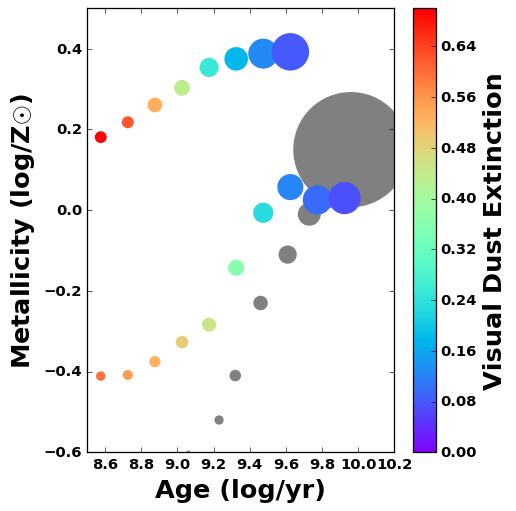

In [8]:
fig = figure(figsize=(6, 6))
xlim(8.5, 10.2)
ylim(-0.6, 0.5)
xlabel("Age (log/yr)")
ylabel("Metallicity (log/Z$\odot$)")

scatter(galtab2[:, 4], galtab2[:, 1], s=10**galtab2[:, 0]/1e8, c="0.5", marker="o")

t, z = binner(s["log_t_L_mod"][c1m], s["log_Z_L_mod"][c1m], "mean", 10, [8.5, 10.])
t, m = binner(s["log_t_L_mod"][c1m], s["M_mod"][c1m], "mean", 10, [8.5, 10.])
t, d = binner(s["log_t_L_mod"][c1m], s["Av_mod"][c1m], "mean", 10, [8.5, 10.])
scatter(t, z, s=10**m/1e8, c=d, cmap=cm.rainbow, vmin=0.0, vmax=0.7, marker="o")

t, z = binner(s["log_t_L_mod"][c2m], s["log_Z_L_mod"][c2m], "mean", 10, [8.5, 10.])
t, m = binner(s["log_t_L_mod"][c2m], s["M_mod"][c2m], "mean", 10, [8.5, 10.])
t, d = binner(s["log_t_L_mod"][c2m], s["Av_mod"][c2m], "mean", 10, [8.5, 10.])
scatter(t, z, s=10**m/1e8, c=d, cmap=cm.rainbow, vmin=0.0, vmax=0.7, marker="o")

cb = colorbar()
cb.set_label("Visual Dust Extinction")
tight_layout()
savefig("age_met_ext")

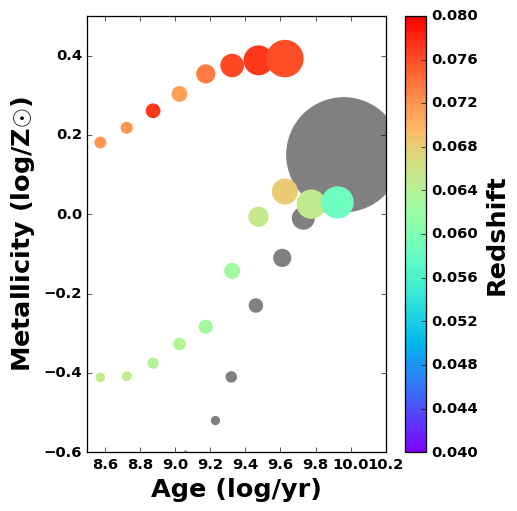

In [9]:
fig = figure(figsize=(6, 6))
xlim(8.5, 10.2)
ylim(-0.6, 0.5)
xlabel("Age (log/yr)")
ylabel("Metallicity (log/Z$\odot$)")

scatter(galtab2[:, 4], galtab2[:, 1], s=10**galtab2[:, 0]/1e8, c="0.5", marker="o")

t, z = binner(s["log_t_L_mod"][c1m], s["log_Z_L_mod"][c1m], "mean", 10, [8.5, 10.])
t, m = binner(s["log_t_L_mod"][c1m], s["M_mod"][c1m], "mean", 10, [8.5, 10.])
t, d = binner(s["log_t_L_mod"][c1m], cat["redshift"][c1m], "mean", 10, [8.5, 10.])
scatter(t, z, s=10**m/1e8, c=d, cmap=cm.rainbow, vmin=0.04, vmax=0.08, marker="o")

t, z = binner(s["log_t_L_mod"][c2m], s["log_Z_L_mod"][c2m], "mean", 10, [8.5, 10.])
t, m = binner(s["log_t_L_mod"][c2m], s["M_mod"][c2m], "mean", 10, [8.5, 10.])
t, d = binner(s["log_t_L_mod"][c2m], cat["redshift"][c2m], "mean", 10, [8.5, 10.])
scatter(t, z, s=10**m/1e8, c=d, cmap=cm.rainbow, vmin=0.04, vmax=0.08, marker="o")

cb = colorbar()
cb.set_label("Redshift")

tight_layout()
savefig("age_met_red")

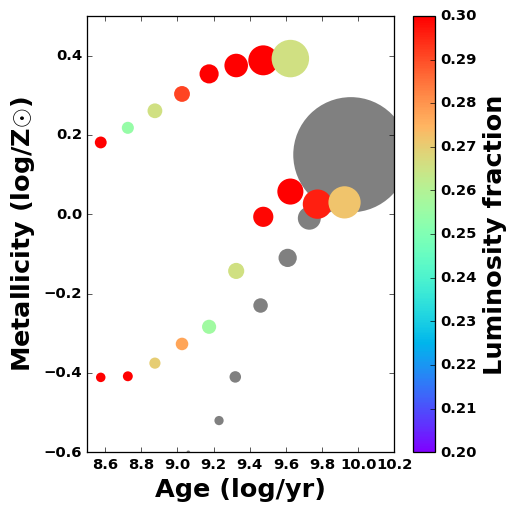

In [25]:
fig = figure(figsize=(6, 6))
xlim(8.5, 10.2)
ylim(-0.6, 0.5)
xlabel("Age (log/yr)")
ylabel("Metallicity (log/Z$\odot$)")

scatter(galtab2[:, 4], galtab2[:, 1], s=10**galtab2[:, 0]/1e8, c="0.5", marker="o")

t, z = binner(s["log_t_L_mod"][c1m], s["log_Z_L_mod"][c1m], "mean", 10, [8.5, 10.])
t, m = binner(s["log_t_L_mod"][c1m], s["M_mod"][c1m], "mean", 10, [8.5, 10.])
t, d = binner(s["log_t_L_mod"][c1m], rat[c1m], "mean", 10, [8.5, 10.])
scatter(t, z, s=10**m/1e8, c=d, cmap=cm.rainbow, vmin=0.2, vmax=0.3, marker="o")

t, z = binner(s["log_t_L_mod"][c2m], s["log_Z_L_mod"][c2m], "mean", 10, [8.5, 10.])
t, m = binner(s["log_t_L_mod"][c2m], s["M_mod"][c2m], "mean", 10, [8.5, 10.])
t, d = binner(s["log_t_L_mod"][c2m], rat[c2m], "mean", 10, [8.5, 10.])
scatter(t, z, s=10**m/1e8, c=d, cmap=cm.rainbow, vmin=0.2, vmax=0.3, marker="o")

cb = colorbar()
cb.set_label("Luminosity fraction")

tight_layout()
savefig("age_met_red")

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:1: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 19552 but corresponding boolean dimension is 16347
  if __name__ == '__main__':
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:2: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 19552 but corresponding boolean dimension is 16347
  from ipykernel import kernelapp as app
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:3: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 19552 but corresponding boolean dimension is 16347
  app.launch_new_instance()


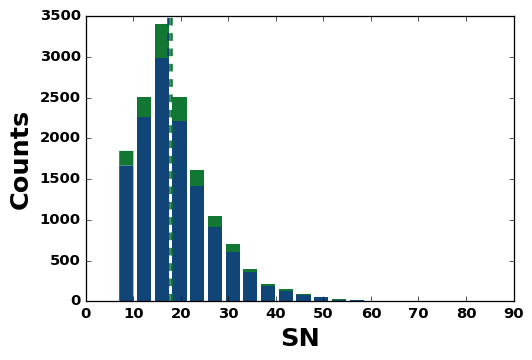

In [10]:
hist([SN[gmask][c1m], SN[gmask][c2m]], 20, histtype="barstacked", lw=0, color=[colors[0], colors[1]])
axvline(median(SN[gmask][c1m]), ls="--", color=colors[0], lw=2)
axvline(median(SN[gmask][c2m]), ls="--", color=colors[1], lw=2)
xlabel("SN")
ylabel("Counts")

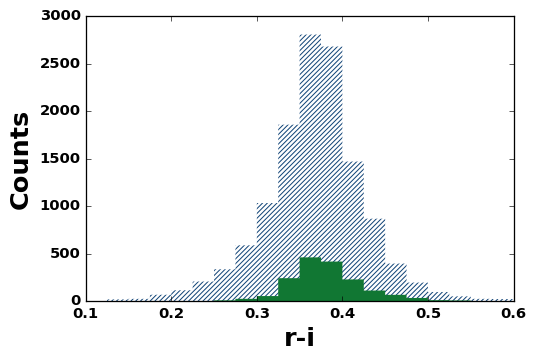

In [11]:
hist((cat["r_mag"]-cat["i_mag"])[c1m], 20, range=(0.1, 0.6), histtype="step", hatch="/////", lw=0, color=colors[0])
hist((cat["r_mag"]-cat["i_mag"])[c2m], 20, range=(0.1, 0.6), histtype="stepfilled", lw=0, color=colors[1])
xlabel("r-i")
ylabel("Counts")
#savefig("r-i.png", bbox_inches="tight")

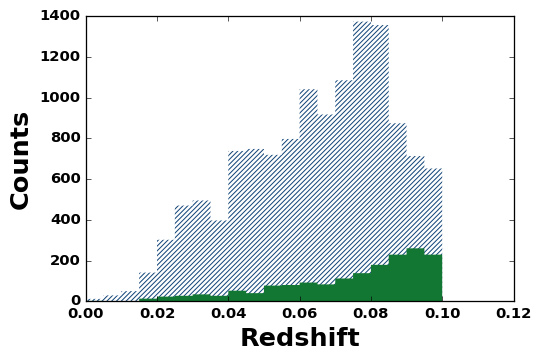

In [12]:
hist(cat["redshift"][c1m], 20, range=(0., 0.1), histtype="step", hatch="/////", lw=0, color=colors[0])
hist(cat["redshift"][c2m], 20, range=(0., 0.1), histtype="stepfilled", lw=0, color=colors[1])

xlabel("Redshift")
ylabel("Counts")

#savefig("redshift.png", bbox_inches="tight")

(0, 1)

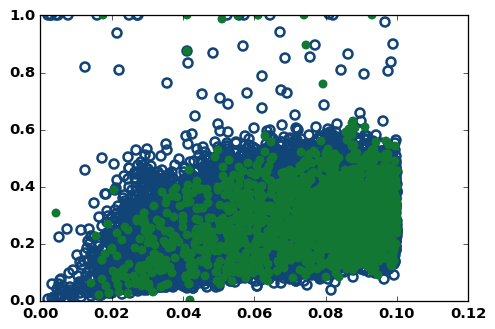

In [17]:
plot(cat["redshift"][c1m], rat[c1m], "o", mfc="none", mec=colors[0], mew=2)
plot(cat["redshift"][c2m], rat[c2m], "o", mfc=colors[1])

ylim(0, 1)